In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [6]:
folder_bronze = '/content/drive/Shareddrives/Real_Project_Churn_DSA30/Dataset/Bronze'
folder_prata = '/content/drive/Shareddrives/Real_Project_Churn_DSA30/Dataset/Prata'
folder_ouro = '/content/drive/Shareddrives/Real_Project_Churn_DSA30/Dataset/Ouro'

In [7]:
df_features = pd.read_csv(os.path.join(folder_prata , 'df_abt_tratado.csv'))
df_features_vecnto = pd.read_csv(os.path.join(folder_prata , 'df_abt_vecnto_tratado.csv'))
df_members = pd.read_csv(os.path.join(folder_bronze , 'df_members.csv'))

In [8]:
df = pd.merge(df_features_vecnto, df_members, on='msno', how='left')

In [9]:
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'].astype(str))
df['registration_init_time'] = df['registration_init_time'].dt.date
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'])

df['membership_expire_date'] = pd.to_datetime(df['membership_expire_date'])

df['time_first_registration'] = (df['membership_expire_date'] - df['registration_init_time']).dt.days

In [10]:
df['membership_expire_date'].value_counts().to_excel('membership_expire_date.xlsx')

In [11]:
df['gender'] = np.where(df['gender'] == 'male', 1, 0)

In [12]:
df_oot = df[df['membership_expire_date'] >= pd.to_datetime('2017-01-01')]
df = df[df['membership_expire_date'] >= pd.to_datetime('2015-01-01')]
df = df[df['membership_expire_date'] < pd.to_datetime('2017-01-01')]

In [13]:
df['membership_expire_date'][df['churn'] == 1].value_counts().to_excel('churns_por_mês.xlsx')
df['membership_expire_date'].value_counts().to_excel('total_por_mês.xlsx')

In [14]:
X = df.drop(['msno', 'membership_expire_date', 'churn', 'city', 'registered_via', 'registration_init_time', 'payment_method_id'], axis=1)
X_oot = df_oot.drop(['msno', 'membership_expire_date', 'churn', 'city', 'registered_via', 'registration_init_time', 'payment_method_id'], axis=1)
y = np.where(df['churn'] == True, 1, 0)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1617955 entries, 0 to 1685177
Data columns (total 22 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   is_auto_renew            1617955 non-null  int64  
 1   is_cancel                1617955 non-null  int64  
 2   payment_plan_days        1617955 non-null  int64  
 3   plan_list_price          1617955 non-null  int64  
 4   actual_amount_paid       1617955 non-null  int64  
 5   sum_25_91_dias           1617955 non-null  float64
 6   sum_50_91_dias           1617955 non-null  float64
 7   sum_75_91_dias           1617955 non-null  float64
 8   sum_985_91_dias          1617955 non-null  float64
 9   sum_100_91_dias          1617955 non-null  float64
 10  sum_unq_91_dias          1617955 non-null  float64
 11  sum_total_secs_91_dias   1617955 non-null  float64
 12  AVG_num_25_91_dias       1617955 non-null  float64
 13  AVG_num_50_91_dias       1617955 non-null  floa

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [17]:
colunas = X_train.columns
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_oot = scaler.transform(X_oot)

In [18]:
ratio_negativos_positivos = (len(y_train[y_train == 0]) / len(y_train[y_train == 1])) / 2

model = XGBClassifier(
    scale_pos_weight=ratio_negativos_positivos,
    eval_metric="aucpr",
    random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

precision_train = precision_score(y_train, y_train_pred)
precision_val = precision_score(y_val, y_val_pred)
precision_test = precision_score(y_test, y_test_pred)

recall_train = recall_score(y_train, y_train_pred)
recall_val = recall_score(y_val, y_val_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"Acurácia (Treino): {accuracy_train}")
print(f"Acurácia (Validação): {accuracy_val}")
print(f"Acurácia (Teste): {accuracy_test}")

print(f"Precisão (Treino): {precision_train}")
print(f"Precisão (Validação): {precision_val}")
print(f"Precisão (Teste): {precision_test}")

print(f"Recall (Treino): {recall_train}")
print(f"Recall (Validação): {recall_val}")
print(f"Recall (Teste): {recall_test}")

Acurácia (Treino): 0.8912454301881079
Acurácia (Validação): 0.8869776971547416
Acurácia (Teste): 0.8868633552849121
Precisão (Treino): 0.5021273561360557
Precisão (Validação): 0.48316470393100014
Precisão (Teste): 0.48675274988044
Recall (Treino): 0.5972406773910831
Recall (Validação): 0.580080791989076
Recall (Teste): 0.5733761478226579


In [19]:
# # talvez excluir, compara muitas coias:


# from xgboost import XGBClassifier
# from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# import pandas as pd

# # Lista de configurações
# configs = [
#     {"scale_pos_weight": 1, "eval_metric": None, "label": "Sem scale_pos_weight, sem aucpr"},
#     {"scale_pos_weight": "auto", "eval_metric": None, "label": "Com scale_pos_weight, sem aucpr"},
#     {"scale_pos_weight": 1, "eval_metric": "aucpr", "label": "Sem scale_pos_weight, com aucpr"},
#     {"scale_pos_weight": "auto", "eval_metric": "aucpr", "label": "Com scale_pos_weight, com aucpr"},
# ]

# # Resultados
# resultados = []

# # Cross-validation
# kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# for config in configs:
#     precisions = []
#     recalls = []
#     f1s = []

#     for train_index, val_index in kf.split(X_train, y_train):
#         X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
#         y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

#         if config["scale_pos_weight"] == "auto":
#             ratio = (len(y_train_cv[y_train_cv == 0]) / len(y_train_cv[y_train_cv == 1])) / 2
#         else:
#             ratio = config["scale_pos_weight"]

#         model = XGBClassifier(
#             scale_pos_weight=ratio,
#             eval_metric=config["eval_metric"],
#             use_label_encoder=False,
#             random_state=42
#         )

#         model.fit(X_train_cv, y_train_cv)
#         y_pred = model.predict(X_val_cv)

#         precisions.append(precision_score(y_val_cv, y_pred))
#         recalls.append(recall_score(y_val_cv, y_pred))
#         f1s.append(f1_score(y_val_cv, y_pred))

#     resultados.append({
#         "Configuração": config["label"],
#         "Precision": np.mean(precisions),
#         "Recall": np.mean(recalls),
#         "F1 Score": np.mean(f1s)
#     })

# # Criar DataFrame e mostrar
# df_resultados = pd.DataFrame(resultados)
# print(df_resultados)


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

# Duas configurações para comparação
configs = [
    {"scale_pos_weight": 1, "label": "Sem SPW + AUC-PR"},
    {"scale_pos_weight": "auto", "label": "Com SPW + AUC-PR"},
]

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
resultados_particoes = []

X_cv = X_test
y_cv = y_test


for config in configs:
    print(f"Avaliando configuração: {config['label']}")
    for fold, (train_index, val_index) in enumerate(kf.split(X_cv, y_cv)):
        X_train_cv, X_val_cv = X_cv[train_index], X_cv[val_index]
        y_train_cv, y_val_cv = y_cv[train_index], y_cv[val_index]

        # Calcula o ratio de pesos se necessário
        if config["scale_pos_weight"] == "auto":
            ratio = (len(y_train_cv[y_train_cv == 0]) / len(y_train_cv[y_train_cv == 1])) / 2
        else:
            ratio = config["scale_pos_weight"]

        # Treina o modelo
        model = XGBClassifier(
            scale_pos_weight=ratio,
            eval_metric="aucpr",
            use_label_encoder=False,
            random_state=42
        )
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_val_cv)
        y_proba = model.predict_proba(X_val_cv)[:, 1]

        # Armazena métricas
        resultados_particoes.append({
            "Configuração": config["label"],
            "Partição": f"Fold {fold+1}",
            "Precision": precision_score(y_val_cv, y_pred),
            "Recall": recall_score(y_val_cv, y_pred),
            "F1 Score": f1_score(y_val_cv, y_pred),
            "AUC-ROC": roc_auc_score(y_val_cv, y_proba)
        })

# Cria DataFrame com os resultados por partição
df_particoes = pd.DataFrame(resultados_particoes)

# Agrupamento final (médias)
df_resumo = df_particoes.groupby("Configuração").mean(numeric_only=True).reset_index()
df_resumo["Partição"] = "Média"

# Junta os dois resultados
df_final = pd.concat([df_particoes, df_resumo], ignore_index=True)

# Exibe tabela
print(df_final.sort_values(["Configuração", "Partição"]))


Avaliando configuração: Sem SPW + AUC-PR


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:19:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:19:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:20:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:20:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Avaliando configuração: Com SPW + AUC-PR


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:20:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:20:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:20:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:20:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


       Configuração Partição  Precision    Recall  F1 Score   AUC-ROC
4  Com SPW + AUC-PR   Fold 1   0.479089  0.564056  0.518112  0.834235
5  Com SPW + AUC-PR   Fold 2   0.487137  0.556782  0.519636  0.837047
6  Com SPW + AUC-PR   Fold 3   0.489818  0.563655  0.524149  0.839692
7  Com SPW + AUC-PR   Fold 4   0.483108  0.552676  0.515556  0.831739
8  Com SPW + AUC-PR    Média   0.484788  0.559292  0.519363  0.835678
0  Sem SPW + AUC-PR   Fold 1   0.773250  0.348507  0.480466  0.836407
1  Sem SPW + AUC-PR   Fold 2   0.785475  0.343623  0.478094  0.837735
2  Sem SPW + AUC-PR   Fold 3   0.787229  0.351397  0.485901  0.840808
3  Sem SPW + AUC-PR   Fold 4   0.783420  0.340732  0.474912  0.833014
9  Sem SPW + AUC-PR    Média   0.782343  0.346065  0.479843  0.836991


In [21]:
# model_tuned = TunedThresholdClassifierCV(model, scoring="balanced_accuracy").fit(X_train, y_train)

# print(f"Cut-off point found at {model_tuned.best_threshold_:.3f}")

# print(classification_report(y_test, model_tuned.predict(X_test)))

In [22]:
# y_probs_train = model_tuned.predict_proba(X_train)[:, 1]
# y_probs_val = model_tuned.predict_proba(X_val)[:, 1]
# y_probs_test = model_tuned.predict_proba(X_test)[:, 1]

y_probs_train = model.predict_proba(X_train)[:, 1]
y_probs_val = model.predict_proba(X_val)[:, 1]
y_probs_test = model.predict_proba(X_test)[:, 1]

In [23]:
def plot_metrics(y_true, y_scores, threshold):
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    auc_roc = auc(fpr, tpr)
    print(precision, recall)
    auc_pr = auc(recall, precision)

    print("Classification Report:")
    y_pred = (y_scores >= threshold).astype(int)
    print(classification_report(y_true, y_pred))

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=axs[0])
    axs[0].set_title(f"Precision-Recall Curve (AUC = {auc_pr:.3f})")
    axs[0].axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.3f}')
    axs[0].legend()

    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[1])
    axs[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label = 'Referência (modelo aleatório)')
    axs[1].set_title(f"ROC Curve (AUC = {auc_roc:.3f})")
    axs[1].set_xlabel('Taxa de Falsos Positivos (FPR)')
    axs[1].set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
    axs[1].axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.3f}')
    axs[1].legend()

    plt.show()


In [24]:
def plot_metrics(y_true, y_scores, threshold):
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    auc_roc = auc(fpr, tpr)

    print("Classification Report:")
    y_pred = (y_scores >= threshold).astype(int)
    print(classification_report(y_true, y_pred))

    # Plot ROC Curve com tamanho customizado
    fig, ax = plt.subplots(figsize=(14, 8))  # Aumenta aqui se quiser maior ainda
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Referência (modelo aleatório)')
    ax.set_title(f"ROC Curve (AUC = {auc_roc:.3f})")
    ax.set_xlabel('Taxa de Falsos Positivos (FPR)')
    ax.set_ylabel('Taxa de Verdadeiros Positivos (TPR)')
    ax.grid(True)
    ax.legend()
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    864660
           1       0.48      0.56      0.52    106113

    accuracy                           0.89    970773
   macro avg       0.72      0.74      0.73    970773
weighted avg       0.89      0.89      0.89    970773



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


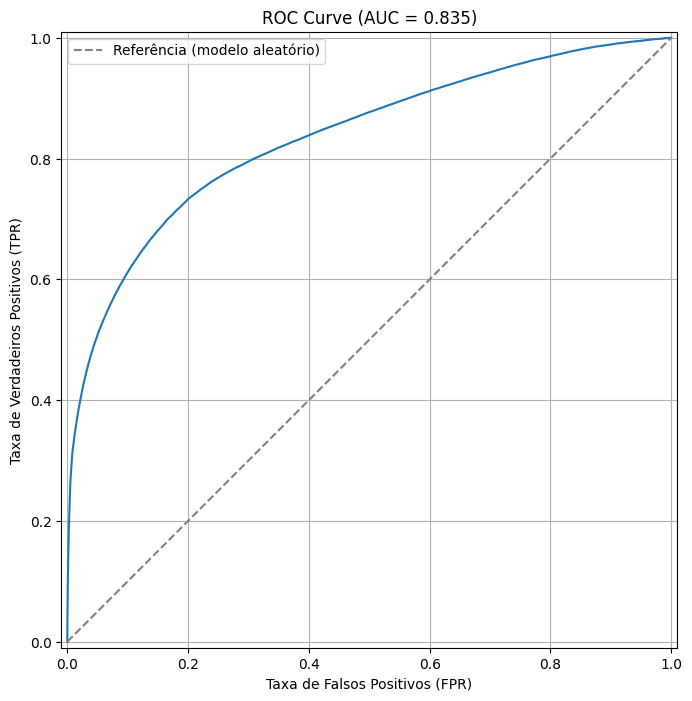

In [25]:
# plot_metrics(y_train, y_probs_train, model_tuned.best_threshold_)
plot_metrics(y_train, y_probs_train, 0.5)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    288439
           1       0.48      0.57      0.52     35152

    accuracy                           0.89    323591
   macro avg       0.71      0.75      0.73    323591
weighted avg       0.90      0.89      0.89    323591



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


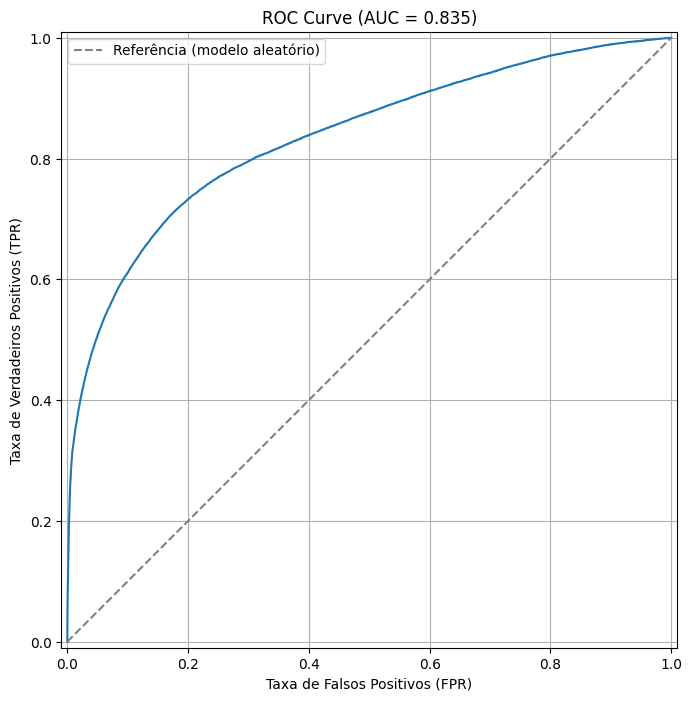

In [26]:
plot_metrics(y_val, y_probs_val, 0.5)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94    288089
           1       0.53      0.61      0.56     35502

    accuracy                           0.90    323591
   macro avg       0.74      0.77      0.75    323591
weighted avg       0.90      0.90      0.90    323591



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


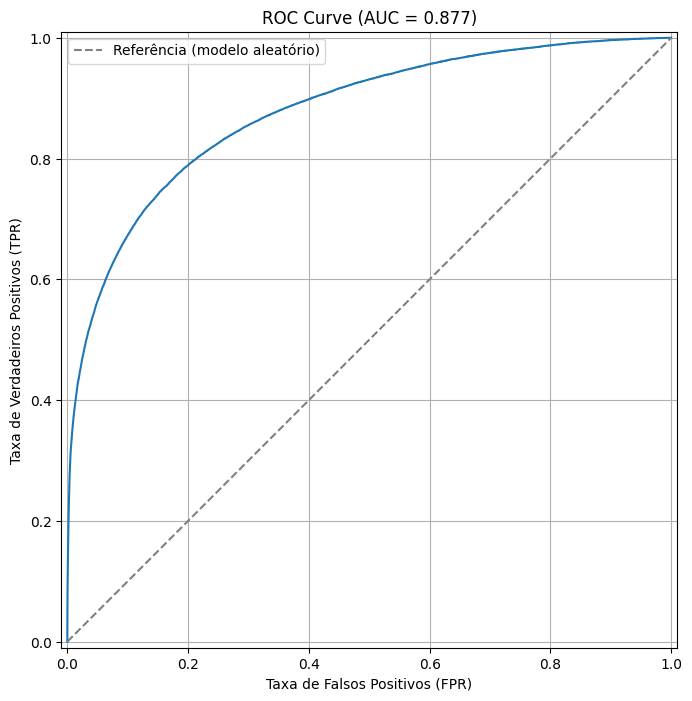

In [27]:
plot_metrics(y_test, y_probs_test, 0.5)

In [28]:
scoragem = model.predict_proba(X_oot)[:, 1]

In [29]:
scoragem

array([0.10827424, 0.07004443, 0.16226162, ..., 0.21312313, 0.58751863,
       0.05666358], dtype=float32)

In [30]:
base_scorada = pd.DataFrame({
    'msno': df_oot['msno'].values,
    'valor_plano':df_oot['plan_list_price'].values,
    'valor_pago':df_oot['actual_amount_paid'].values,
    'data_vencimento':df_oot['membership_expire_date'].values,
    'scoragem': scoragem
})

In [31]:
base_scorada.to_excel(os.path.join(folder_ouro, 'df_base_scorada_mês.xlsx'))

In [32]:
df_oot.shape

(66483, 29)

In [33]:
# Extraindo importância das features
importances = model.feature_importances_
feature_names = colunas  # Nomes das colunas

# Ordenando por importância
sorted_idx = np.argsort(importances)[::-1]


# Criando um DataFrame e ordenando
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

# Pegando as top 10 features
top_10_xgb = feat_importance_df.head(10)
print(top_10_xgb)

def plot_top_features(top_features_df):
    plt.figure(figsize=(12, 7))
    bars = plt.bar(
        top_features_df['Feature'],
        top_features_df['Importance'],
        color=plt.cm.viridis(np.linspace(0.2, 0.8, len(top_features_df)))
    )

    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importância", fontsize=12)
    plt.title("Top 10 Features - XGBoost", fontsize=14, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Remover bordas desnecessárias
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()


                   Feature  Importance
0            is_auto_renew    0.563214
1                is_cancel    0.208933
4       actual_amount_paid    0.106284
2        payment_plan_days    0.028684
10         sum_unq_91_dias    0.012861
11  sum_total_secs_91_dias    0.012543
3          plan_list_price    0.009172
6           sum_50_91_dias    0.005526
8          sum_985_91_dias    0.005439
9          sum_100_91_dias    0.005041


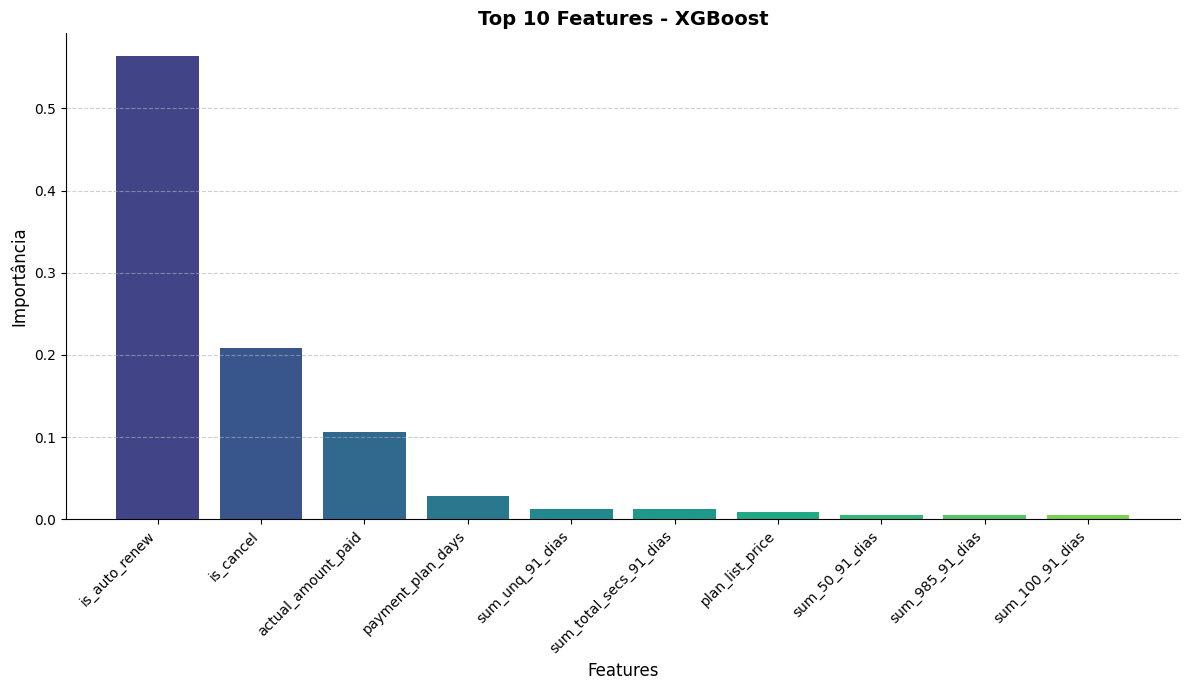

In [34]:
plot_top_features(top_10_xgb)

In [35]:
# # Treinamos o modelo com GradientBoostingClassifier
# model = GradientBoostingClassifier(
#     n_estimators=100,      # Número de árvores
#     learning_rate=0.3,     # Taxa de aprendizado
#     max_depth=3,           # Profundidade máxima das árvores
#     random_state=42        # Semente para reprodutibilidade
# )

# # Treinando o modelo
# model.fit(X_train, y_train)

# # Fazendo previsões no conjunto de validação
# y_val_pred = model.predict(X_val)

# # Avaliando o modelo
# print("Avaliação no Conjunto de Validação do 'Gradient Bossting:'")
# print("Acurácia:", accuracy_score(y_val, y_val_pred))
# print("Precisão:", precision_score(y_val, y_val_pred))
# print("Recall:", recall_score(y_val, y_val_pred))
# print("F1-score:", f1_score(y_val, y_val_pred))
# print("Matriz de Confusão:\n", confusion_matrix(y_val, y_val_pred))

In [36]:
# fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
# auc_score = roc_auc_score(y_val, y_val_pred)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc_score:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
# plt.xlabel('Taxa de Falsos Positivos (FPR)')
# plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
# plt.title('Curva ROC')
# plt.legend()
# plt.grid()
# plt.show()

In [37]:
# model = CatBoostClassifier(
#     iterations=500,  # Número de árvores
#     learning_rate=0.1,
#     depth=6,
#     verbose=100
# )

# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

In [38]:
# y_train_pred = model.predict(X_train)
# y_val_pred = model.predict(X_val)
# y_test_pred = model.predict(X_test)

# accuracy_train = accuracy_score(y_train, y_train_pred)
# accuracy_val = accuracy_score(y_val, y_val_pred)
# accuracy_test = accuracy_score(y_test, y_test_pred)

# precision_train = precision_score(y_train, y_train_pred)
# precision_val = precision_score(y_val, y_val_pred)
# precision_test = precision_score(y_test, y_test_pred)

# recall_train = recall_score(y_train, y_train_pred)
# recall_val = recall_score(y_val, y_val_pred)
# recall_test = recall_score(y_test, y_test_pred)

# print(f"Acurácia (Treino): {accuracy_train}")
# print(f"Acurácia (Validação): {accuracy_val}")
# print(f"Acurácia (Teste): {accuracy_test}")

# print(f"Precisão (Treino): {precision_train}")
# print(f"Precisão (Validação): {precision_val}")
# print(f"Precisão (Teste): {precision_test}")

# print(f"Recall (Treino): {recall_train}")
# print(f"Recall (Validação): {recall_val}")
# print(f"Recall (Teste): {recall_test}")

In [39]:
# fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
# auc_score = roc_auc_score(y_val, y_val_pred)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {auc_score:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de referência
# plt.xlabel('Taxa de Falsos Positivos (FPR)')
# plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
# plt.title('Curva ROC')
# plt.legend()
# plt.grid()
# plt.show()

In [40]:
# clf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight={1:0.11, 0:.89})

# clf.fit(X_train, y_train)
# y_train_pred = clf.predict(X_train)
# y_val_pred = clf.predict(X_val)
# y_test_pred = clf.predict(X_test)

# accuracy_train = accuracy_score(y_train, y_train_pred)
# accuracy_val = accuracy_score(y_val, y_val_pred)
# accuracy_test = accuracy_score(y_test, y_test_pred)

# precision_train = precision_score(y_train, y_train_pred)
# precision_val = precision_score(y_val, y_val_pred)
# precision_test = precision_score(y_test, y_test_pred)

# recall_train = recall_score(y_train, y_train_pred)
# recall_val = recall_score(y_val, y_val_pred)
# recall_test = recall_score(y_test, y_test_pred)

# print(f"Acurácia (Treino): {accuracy_train}")
# print(f"Acurácia (Validação): {accuracy_val}")
# print(f"Acurácia (Teste): {accuracy_test}")

# print(f"Precisão (Treino): {precision_train}")
# print(f"Precisão (Validação): {precision_val}")
# print(f"Precisão (Teste): {precision_test}")

# print(f"Recall (Treino): {recall_train}")
# print(f"Recall (Validação): {recall_val}")
# print(f"Recall (Teste): {recall_test}")
